In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import keras_tuner as kt

In [2]:
np.random.seed(42)
data = {
    'Temperature': np.random.uniform(20, 40, 1000),
    'Rainfall': np.random.uniform(100, 300, 1000),
    'Soil_pH': np.random.uniform(5.5, 8.5, 1000),
    'Soil_Moisture': np.random.uniform(10, 30, 1000),
    'Fertilizer_Used': np.random.uniform(50, 200, 1000),
    'Crop_Type': np.random.choice(['Rice', 'Wheat', 'Maize'], 1000),
    'Yield': np.random.uniform(1, 5, 1000)
}
df = pd.DataFrame(data)
encoder = LabelEncoder()
df['Crop_Type'] = encoder.fit_transform(df['Crop_Type'])
X = df.drop('Yield', axis=1)
y = df['Yield']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
scaler = StandardScaler()
X_train[['Temperature', 'Rainfall', 'Soil_pH', 'Soil_Moisture', 'Fertilizer_Used']] = scaler.fit_transform(X_train[['Temperature', 'Rainfall', 'Soil_pH', 'Soil_Moisture', 'Fertilizer_Used']])
X_test[['Temperature', 'Rainfall', 'Soil_pH', 'Soil_Moisture', 'Fertilizer_Used']] = scaler.transform(X_test[['Temperature', 'Rainfall', 'Soil_pH', 'Soil_Moisture', 'Fertilizer_Used']])
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_input', min_value=32, max_value=256, step=32), activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_input', 0.2, 0.5, step=0.1)))
    for i in range(hp.Int('num_layers', 2, 5)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32), activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float(f'dropout_{i}', 0.2, 0.5, step=0.1)))
    model.add(Dense(1)) 
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model
tuner = kt.RandomSearch(build_model, objective='val_mae', max_trials=5, executions_per_trial=2, directory='tuner_dir', project_name='crop_yield_prediction')
tuner.search(X_train, y_train, epochs=20, validation_split=0.2)
best_model = tuner.get_best_models(num_models=1)[0]

Trial 5 Complete [00h 00m 18s]
val_mae: 1.0111846923828125

Best val_mae So Far: 0.9788066744804382
Total elapsed time: 00h 01m 51s


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Ensemble Test MAE: 1.0371815758925413


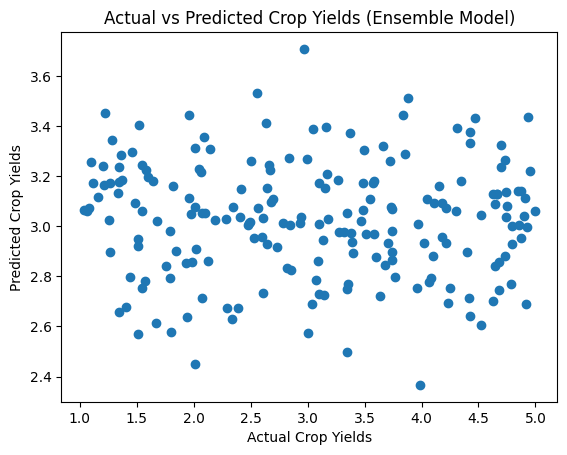

In [5]:
best_model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32, verbose=0)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
nn_predictions = best_model.predict(X_test).flatten()
rf_predictions = rf_model.predict(X_test)
final_predictions = (nn_predictions + rf_predictions) / 2
mae = mean_absolute_error(y_test, final_predictions)
print(f"Ensemble Test MAE: {mae}")
plt.scatter(y_test, final_predictions)
plt.xlabel('Actual Crop Yields')
plt.ylabel('Predicted Crop Yields')
plt.title('Actual vs Predicted Crop Yields (Ensemble Model)')
plt.show()

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.5941 - mae: 1.0803 - val_loss: 1.3509 - val_mae: 1.0081
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4733 - mae: 1.0323 - val_loss: 1.3636 - val_mae: 1.0083
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4787 - mae: 1.0185 - val_loss: 1.3599 - val_mae: 1.0030
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3323 - mae: 0.9697 - val_loss: 1.3962 - val_mae: 1.0128
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4772 - mae: 1.0232 - val_loss: 1.4072 - val_mae: 1.0200
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5245 - mae: 1.0418 - val_loss: 1.3913 - val_mae: 1.0149
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4155 - mae: 1.0097 - val_loss: 1.4148 - val_mae: 1.0199
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5149 - mae: 1.0291 - val_loss: 1.3751 - val_mae: 1.0069
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6298 - mae:

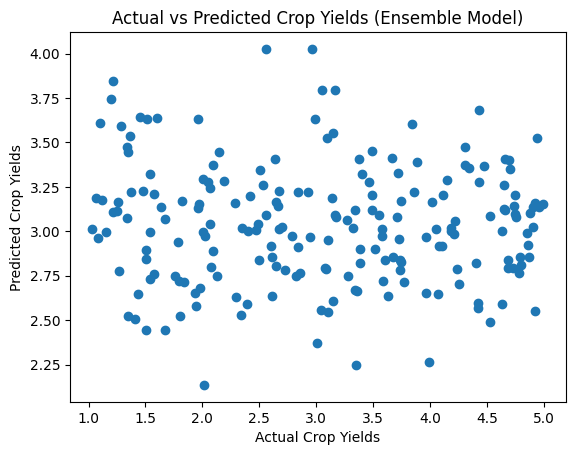

In [9]:
best_model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32, verbose=1)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
nn_predictions = best_model.predict(X_test).flatten()  
rf_predictions = rf_model.predict(X_test)
ensemble_predictions = (nn_predictions + rf_predictions) / 2
mae = mean_absolute_error(y_test, ensemble_predictions)
print(f"Ensemble Test MAE: {mae}")
plt.scatter(y_test, ensemble_predictions)
plt.xlabel('Actual Crop Yields')
plt.ylabel('Predicted Crop Yields')
plt.title('Actual vs Predicted Crop Yields (Ensemble Model)')
plt.show()

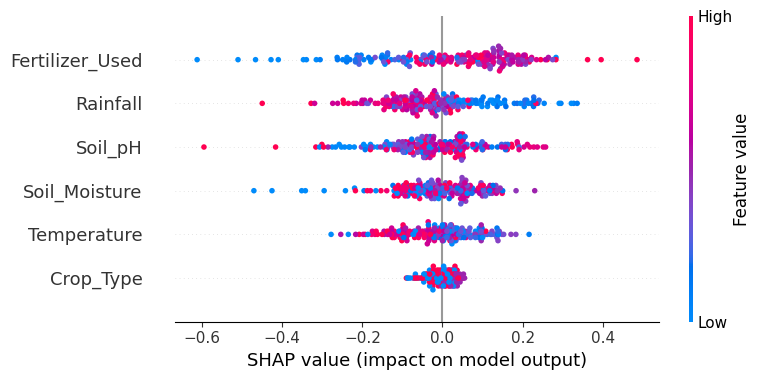

In [11]:
import shap
explainer = shap.Explainer(rf_model, X_train) 
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)